# Mini ML Project

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from functools import partial
from bisect import bisect


## The data

In [3]:
data = pd.read_csv('dataset.csv')
display(data)

,molecule_id,pXC50,b0001,b0002,b0003,b0004,b0005,b0006,b0007,b0008,...,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1022,b1023,b1024
0,CHEMBL10016,7.301,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,CHEMBL10019,6.071,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,CHEMBL10092,5.357,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
3,CHEMBL100954,7.260,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL101069,7.616,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,CHEMBL96723,7.480,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1167,CHEMBL96746,7.572,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1168,CHEMBL96831,5.439,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1169,CHEMBL96906,6.325,1,1,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0


## Useful Functions

In [38]:
# For reproducibility use a random state of 1
def split(df, random_state=1):
    train, test = train_test_split(df, random_state=1)
    x_train = train.drop(["molecule_id", "pXC50"], axis=1)
    x_test = test.drop(["molecule_id", "pXC50"], axis=1)
    y_train = train["pXC50"]
    y_test = test["pXC50"]
    return x_train, x_test, y_train, y_test

## Clean

In [9]:
temp = data.drop(["molecule_id", "pXC50"], axis=1)
for col in temp.columns:
    if len(data[col].unique()) == 1:
        data = data.drop(col, axis=1)
display(data)
data["b1024"].sum()

,molecule_id,pXC50,b0002,b0004,b0005,b0006,b0007,b0008,b0009,b0011,...,b1012,b1013,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1024
0,CHEMBL10016,7.301,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,CHEMBL10019,6.071,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,CHEMBL10092,5.357,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,CHEMBL100954,7.260,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,CHEMBL101069,7.616,1,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166,CHEMBL96723,7.480,1,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1167,CHEMBL96746,7.572,1,0,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
1168,CHEMBL96831,5.439,1,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1169,CHEMBL96906,6.325,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


2

## K nearest neighbours regression

In [40]:
x_train, x_test, y_train, y_test = split(data)

## Own Code
def getNearest(X, x):
    smallest = []
    index = []
    for i in range(X.shape[0]):
        temp = -np.linalg.norm(x-X[i])
        insertAt = bisect(smallest, temp)
        smallest.insert(insertAt, temp)
        index.insert(insertAt, i)
    return index

def trainKNN(X, Y):
    _mse = []
    errors = []
    nearest = []
    for i in range(X.shape[0]):
        nearest.append(getNearest(np.delete(X, i, axis=0), X[i]))
        print(f"\r{i} out of {len(Y)}", end="")
    for i in range(X.shape[0]-1):
        yguess = []
        for j in range(X.shape[0]):
            yguess.append(np.mean(Y[nearest[j]]))
            nearest[j].pop(0)
        _mse.append(mse(yguess, Y))
        print(f'\r{i} down with {len(nearest[0])} left. Most recent mse = {_mse[-1]}', end="")
    

    return _mse



p1 = int() # Number of neighbours to consider
X = np.array(x_train)
Y = np.array(y_train)

meanErrors = trainKNN(X, Y)




876 down with 0 left. Most recent mse = 2.2227373371298405

12


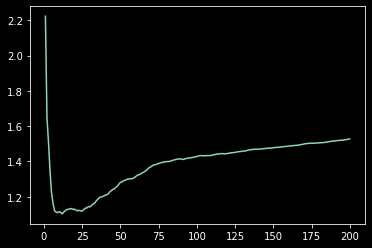

In [41]:
from matplotlib.pyplot import *
x = [i for i in range(X.shape[0]-1, 0, -1)]
plot(x[-200:], meanErrors[-200:])
K = x[np.argmin(meanErrors)]
print(K)

In [42]:
def KNN(X_train, Y_train, x, K):
    X_record = K * [-float("inf")]
    Y_record = K * [None]
    for i in range(X_train.shape[0]):
        diff = -np.linalg.norm(X_train[i] - x)
        if diff > X_record[0]:
            X_record.pop(0)
            Y_record.pop(0)
            index = bisect(X_record, diff)
            X_record.insert(index, diff)
            Y_record.insert(index, Y_train[i])
    return np.mean(Y_record)

y_pred = []
for x in np.array(x_test):
    y_pred.append(KNN(X, Y, x, K))

mse(y_pred, y_test)


0.5529321534414107

In [43]:
KNN_Classifier = KNeighborsRegressor(K)
KNN_Classifier.fit(x_train, y_train)
y_pred = KNN_Classifier.predict(x_test)
mse(y_pred, y_test)

0.5489512646947289

In [8]:
max(data["pXC50"])

10.163